# Search Algorithm No Embedding

In [1]:
from blimpy import Waterfall
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

numexpr.utils   INFO     Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
numexpr.utils   INFO     NumExpr defaulting to 8 threads.


2023-01-23 19:01:01.743451: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Load Model

In [2]:
latent_dim = 5
time_samples = 16
freq_sample =  256
encoder_inputs = keras.Input(shape=(time_samples, freq_sample, 1))
x = layers.Conv2D(16, 3, activation="relu", strides=1, padding="same")(encoder_inputs)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x_shape = x.shape
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(16, activation="relu")(x)
x = layers.BatchNormalization()(x)
z = layers.Dense(latent_dim, name="latent")(x)
encoder = keras.Model(encoder_inputs, z, name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(32, activation="relu")(latent_inputs)
x = layers.BatchNormalization()(x)
x = layers.Dense(x_shape[1]* x_shape[2]* x_shape[3], activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Reshape((x_shape[1], x_shape[2], x_shape[3]))(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="linear", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

2023-01-23 19:01:08.979091: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-23 19:01:09.071991: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-23 19:01:09.186930: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:81:00.0 name: NVIDIA RTX A4000 computeCapability: 8.6
coreClock: 1.56GHz coreCount: 48 deviceMemorySize: 15.74GiB deviceMemoryBandwidth: 417.29GiB/s
2023-01-23 19:01:09.187225: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:a1:00.0 name: NVIDIA RTX A4000 computeCapability: 8.6
coreClock: 1.56GHz coreCount: 48 deviceMemorySize: 15.74GiB deviceMemoryBandwidth: 417.29GiB/s
2023-01-23 19:01:09.187474: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:c1:00.0 name: NVIDIA RTX A

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 256, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 256, 16)       160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 128, 16)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 128, 16)       64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 128, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 64, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 64, 32)        128 

In [3]:
from AE import AE

autoencoder = AE(encoder, decoder)
autoencoder.load_weights("../autoencoder/models/full-weights-"+'12-16-2022-11-47-35')

# Load Data

In [5]:
from tqdm import tqdm
def normalize(data):
    epsilon = 1
    min_val = data.min()
    data = data - min_val + epsilon
    new_data = np.log(data)
    min_val = data.min()
    max_val = data.max()
    final_data = (data - min_val) / (max_val - min_val)
    return final_data
    
def normalize_data(data):
    new_data = np.zeros((data.shape[-1]//256, 16, 256,1))
    for i in tqdm(range(new_data.shape[0])):
        new_data[i,:,:, 0] = normalize(data[:,0, i*256:(i+1)*256])
    return new_data

def find_directory(target, data):
    headers = data.columns.to_list()
    headers.pop(0)
    for key in headers:
        li = data[key].to_list()
        if key != "Unnamed: 0" or key != '':
            for el in li:
                if target in el:
                    return el
    return -1

In [6]:
import pickle

df = pd.read_csv("../data_generator/test_directories.csv")

with open('SOI.pkl', 'rb') as handle:
    SOI = pickle.load(handle)

target1 = '/datag/pipeline/AGBT17A_999_76/holding/spliced_blc0001020304050607_guppi_57907_36075_HIP87579_0036.gpuspec.0000.h5'

print(Waterfall("../../../../../../../"+target1, 
                 f_start = target1["start"], f_stop=target1["end"]).info())
target1_data = Waterfall("../../../../../../../"+target1, 
                 f_start = target1["start"], f_stop=target1["end"]).data


data = Waterfall("../../../../../../../"+target1, max_load=False).data
preprocessed_data = normalize_data(data)


--- File Info ---
DIMENSION_LABELS : [b'frequency' b'feed_id' b'time']
        az_start :                              0.0
       data_type :                                1
            fch1 :                2802.83203125 MHz
            foff :      -2.7939677238464355e-06 MHz
      machine_id :                               20
           nbits :                               32
          nchans :                        359661568
            nifs :                                1
     source_name :                         HIP87579
         src_dej :                     21:19:31.057
         src_raj :                     17:53:29.774
    telescope_id :                                6
           tsamp :                     18.253611008
   tstart (ISOT) :          2017-06-03T09:38:47.000
    tstart (MJD) :                57907.40193287037
        za_start :                              0.0

Num ints in file :                               16
      File shape :               (16, 1, 35

100%|███████████████████████████████████████████████████████████████████████████████████████| 1404928/1404928 [00:48<00:00, 28689.66it/s]


In [6]:
print(data.shape)

(16, 1, 359661568)


# Feature Extractor

In [7]:
key_features = autoencoder.encoder.predict(preprocessed_data, batch_size=1024)
print(key_features.shape)

2022-12-20 14:31:00.276972: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 23018340352 exceeds 10% of free system memory.
2022-12-20 14:31:17.559291: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-20 14:31:17.560830: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200070000 Hz
2022-12-20 14:31:17.747864: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-20 14:31:17.935004: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


(1404928, 5)


# Search Algorithm

In [8]:
eps = 0
SOI_feature = autoencoder.encoder.predict(normalize_data(target1_data), batch_size=1)
print(SOI_feature.shape)
SOI_feature = np.swapaxes(SOI_feature, 0, -1)
SOI_norm = np.linalg.norm(SOI_feature)
data_norm = np.linalg.norm(key_features, axis = 1) + eps
print(key_features.shape)
similarity = np.matmul(key_features, SOI_feature)[:,0]
similarity = np.divide(similarity, data_norm)/SOI_norm
print(similarity)
best_index = (-similarity).argsort()[:-1000]
print(similarity.max())
print(best_index)

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1129.93it/s]


(1, 5)
(1404928, 5)
[0.93552387 0.929239   0.9554161  ... 0.9304319  0.9255808  0.9651847 ]
0.9999998
[1176584 1190706 1172028 ...  442115  444996  445267]


In [9]:
best_index[0]

1176584

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1575.03it/s]


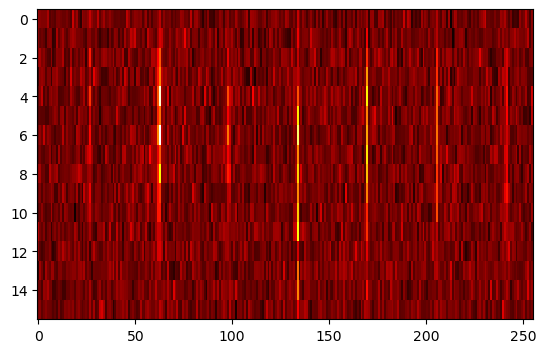

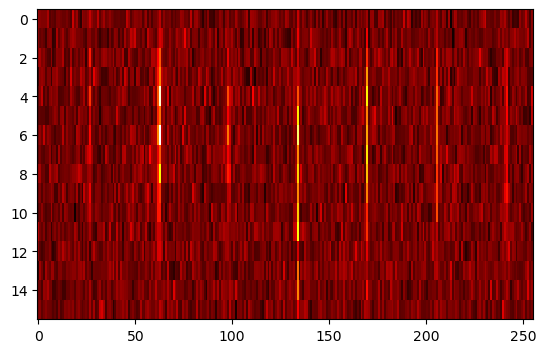

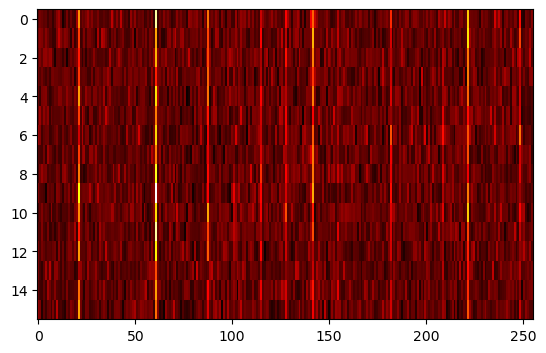

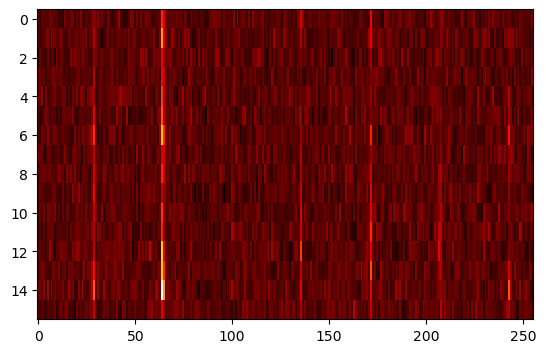

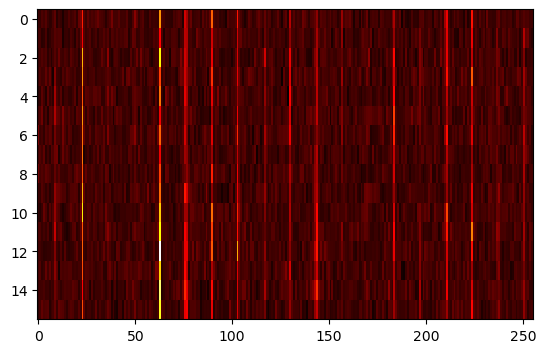

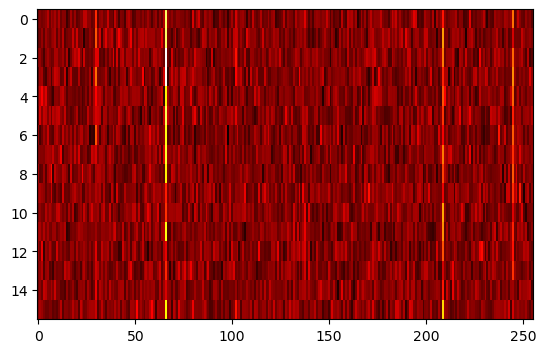

In [10]:
%matplotlib inline

plt.figure()
plt.imshow(normalize_data(target1_data)[0,:,:,0], cmap='hot', interpolation='nearest', aspect=10)

for i in range(5):
    plt.figure()
    plt.imshow(preprocessed_data[best_index[i],:, :], cmap='hot', interpolation='nearest', aspect=10)

### Get some header information

In [16]:
header = Waterfall("../../../../../../../"+target1, 
                 load_data = False).header
end = header['fch1']
foff = header['foff']
nchan = header['nchans']
start = end+nchan*foff
print(start, end)
intervals = (end-start)/similarity.shape[0]
print(intervals)
print( target1["start"])

1797.94921875 2802.83203125
0.0007152557373046875
1961.2728595733643


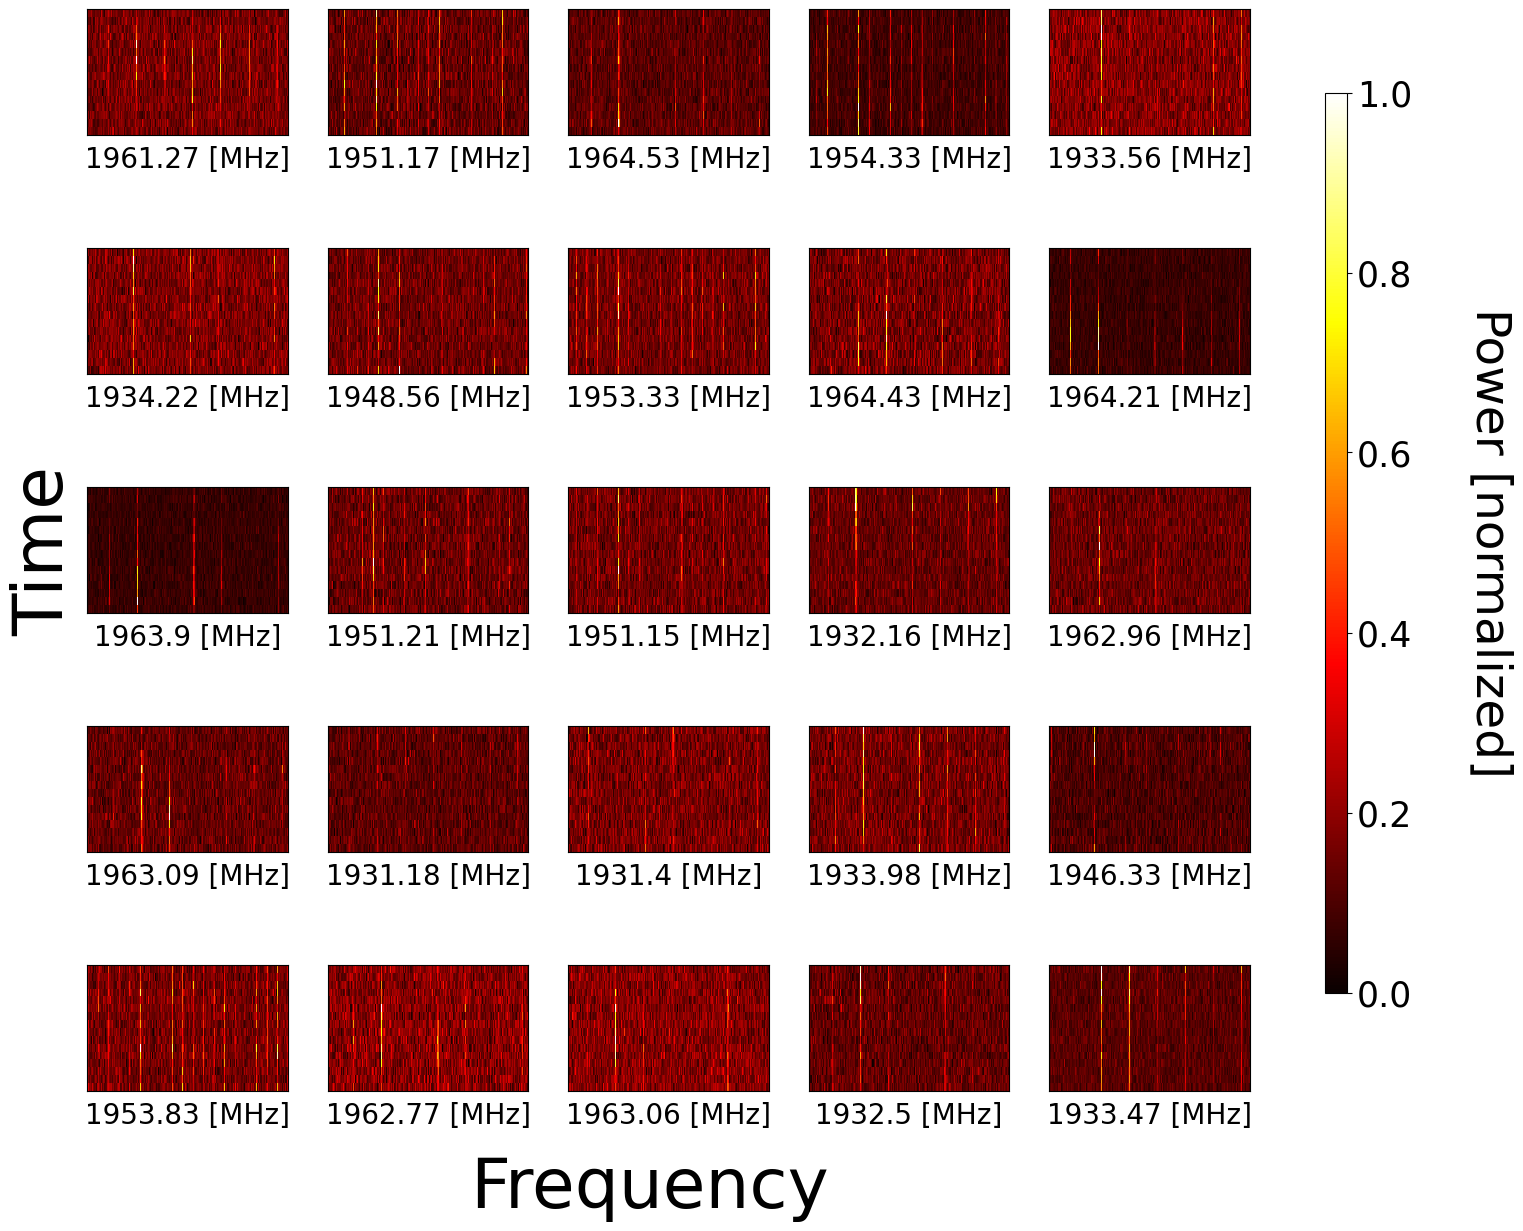

In [17]:
font_size = 25
plt.rcParams.update({'font.size': font_size})
f, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,15))

count = 0
row_count = 0
for row in ax:
    col_count = 0 
    for col in row:
        im = col.imshow(preprocessed_data[best_index[count],:, :], cmap='hot', interpolation='nearest', aspect=10)
        freq = end-best_index[count]*intervals
        col.set_xlabel(str(round(freq, 2))+" [MHz]",  fontsize=font_size-5)  
        col.get_xaxis().set_ticks([])
        col.get_yaxis().set_ticks([])
        if col_count ==0 and row_count == 2:
            col.set_ylabel("Time",  fontsize=font_size*2)  
        col_count+=1
        count += 1 
    row_count += 1
    
f.text(0.5, 0.07, 'Frequency', ha='center', va='center', rotation=0, 
       fontsize=font_size*2)


cbaxes = f.add_axes([0.95, 0.2, 0.015, 0.6]) 
cbar = f.colorbar(im, cax=cbaxes)
cbar.ax.tick_params(labelsize=font_size)
f.text(1.06, 0.5, 'Power [normalized]', ha='center', va='center', rotation=270, 
       fontsize=font_size+10)

plt.show()

# Check Distribution

In [13]:
1176584*intervals+end

3644.3904876708984

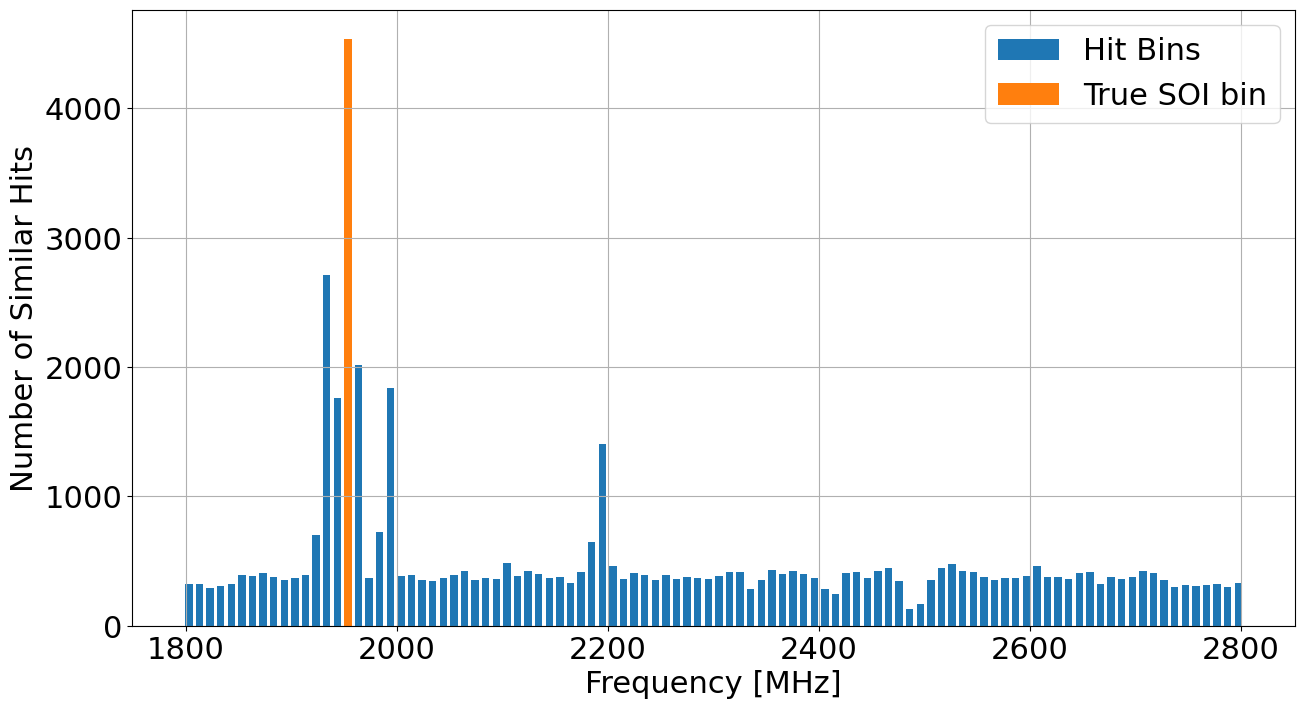

In [14]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(15,8))
hist, bins = np.histogram(end-best_index[:50000]*intervals, bins=100)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width, label="Hit Bins")
key = 0
for i in range(len(center)):
    if center[i] > target1["start"]:
        key = i
        break
plt.bar(center[key-1], hist[key-1], align='center', width=width, label="True SOI bin")
plt.ylabel("Number of Similar Hits")
plt.xlabel("Frequency [MHz]")
plt.grid()
plt.legend()

# Merge Plots Together

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2431.48it/s]


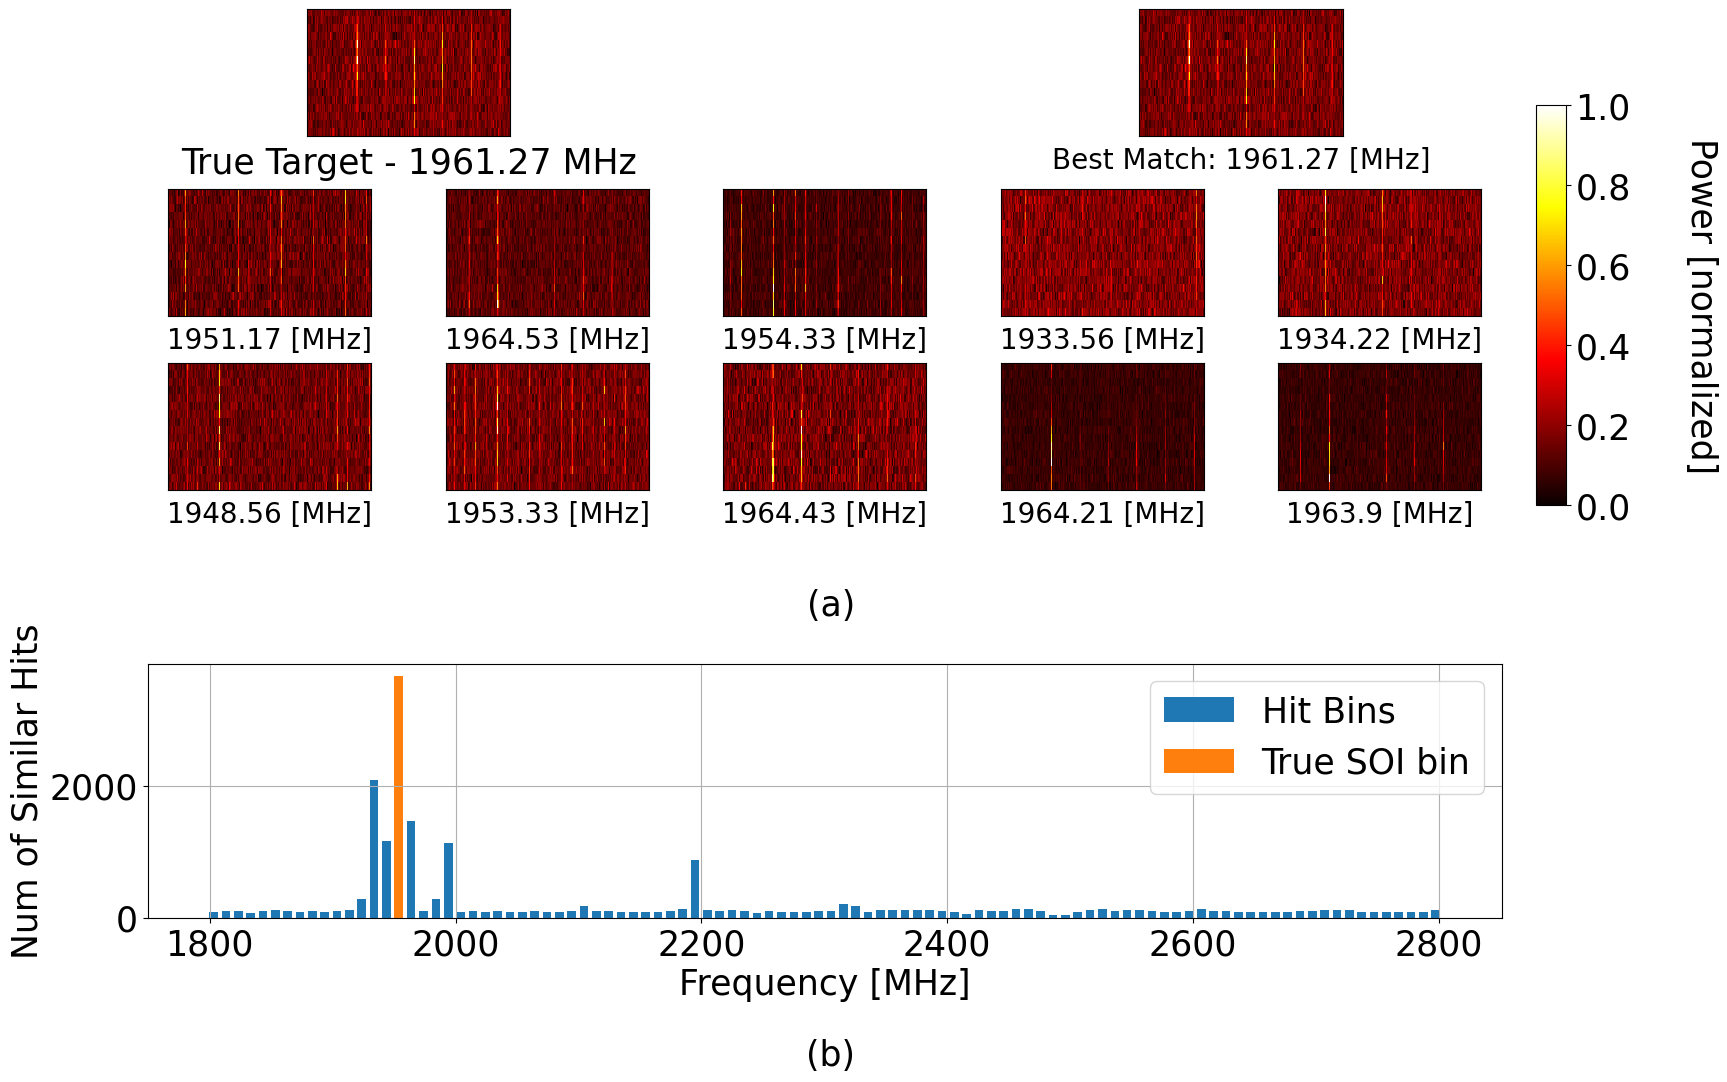

In [18]:
fig = plt.figure(figsize=(15, 10), layout="constrained")
spec = fig.add_gridspec(6, 5)

main = fig.add_subplot(spec[0, 0:2])
im = main.imshow(normalize_data(target1_data)[0,:,:,0], cmap='hot', interpolation='nearest', aspect=10)
main.get_xaxis().set_ticks([])
main.get_yaxis().set_ticks([])
main.set_xlabel("True Target - "+str(round(target1["start"], 2))+" MHz")

ax0 = fig.add_subplot(spec[0, 3:])
im = ax0.imshow(preprocessed_data[best_index[0],:, :], cmap='hot', interpolation='nearest', aspect=10)
ax0.get_xaxis().set_ticks([])
ax0.get_yaxis().set_ticks([])
freq = end-best_index[0]*intervals
ax0.set_xlabel("Best Match: "+str(round(freq, 2))+" [MHz]",  fontsize=font_size-5)          
count = 1
for i in range(1,3):
    for j in range(5):
        ax = fig.add_subplot(spec[i, j])
        im = ax.imshow(preprocessed_data[best_index[count],:, :], cmap='hot', interpolation='nearest', aspect=10)
        freq = end-best_index[count]*intervals
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.set_xlabel(str(round(freq, 2))+" [MHz]",  fontsize=font_size-5)  
        count +=1

fig.text(0.55, 0.40, '(a)', ha='center', va='center', rotation=0, fontsize=font_size)
# histogram
ax1 = fig.add_subplot(spec[4:, :])  
hist, bins = np.histogram(end-best_index[:20000]*intervals, bins=100)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width, label="Hit Bins")
key = 0
for i in range(len(center)):
    if center[i] > target1["start"]:
        key = i
        break
ax1.bar(center[key-1], hist[key-1], align='center', width=width, label="True SOI bin")
ax1.legend()        
ax1.grid()     
ax1.set_xlabel("Frequency [MHz]")
ax1.set_ylabel("Num of Similar Hits")



cbaxes = fig.add_axes([1.02, 0.5, 0.02, 0.4]) 
cbar = fig.colorbar(im, cax=cbaxes)
cbar.ax.tick_params(labelsize=font_size)
fig.text(1.13, 0.70, 'Power [normalized]', ha='center', va='center', rotation=270, 
       fontsize=font_size)

fig.text(0.35, -0.0, '(b)', ha='center', va='center', rotation=0, 
       fontsize=font_size)


target_name = target1['directory'].split("/")[-1].split('.')[0]
plt.savefig("plots/full_algo_noembedding/full_algo_no_embedding-"+target_name+".pdf", format="pdf")